**Financial Crisis Prediction using Macroeconomic Indicators – LSTM**<br>

**A Deep Learning Approach for Binary Recession Forecasting**

**PREPROCESSING AND EDA**

In [ ]:
import pandas as pd
import numpy as np
df=pd.read_csv('/content/current_2023-10_monthly.csv')
usrec_df=pd.read_csv('/content/USRECD.csv')

In [ ]:
usrec_df.head()

,observation_date,USRECD
0,2000-01-01,0
1,2000-01-02,0
2,2000-01-03,0
3,2000-01-04,0
4,2000-01-05,0


In [ ]:
print(df['sasdate'].unique()[:10])  # Check the first 10 unique entries


['Transform:' '1/1/1959' '2/1/1959' '3/1/1959' '4/1/1959' '5/1/1959'
 '6/1/1959' '7/1/1959' '8/1/1959' '9/1/1959']


In [ ]:
df = df[df['sasdate'].str.match(r'^\d', na=False)]


In [ ]:
df['sasdate'] = pd.to_datetime(df['sasdate'], format='%m/%d/%Y')


In [ ]:
usrec_df.rename(columns={'observation_date': 'sasdate'}, inplace=True)


In [ ]:
# Convert both date columns to datetime format
df['sasdate'] = pd.to_datetime(df['sasdate'], format='%m/%d/%Y', errors='coerce')
usrec_df['sasdate'] = pd.to_datetime(usrec_df['sasdate'], format='%Y-%m-%d', errors='coerce')

# Drop any rows where parsing failed
df = df.dropna(subset=['sasdate'])
usrec_df = usrec_df.dropna(subset=['sasdate'])

# Filter df to match the USREC date range
df = df[(df['sasdate'] >= '2000-01-01') & (df['sasdate'] <= '2023-08-01')]

# Merge on 'sasdate'
merged_df = pd.merge(df, usrec_df, on='sasdate', how='inner')


In [ ]:
print(merged_df.head())
print(merged_df.columns)


     sasdate        RPI  W875RX1  DPCERA3M086SBEA  CMRMTSPLx   RETAILx  \
0 2000-01-01  11441.669  10000.3           67.481  1069375.0  268044.0   
1 2000-02-01  11488.814  10045.9           68.116  1050132.0  272020.0   
2 2000-03-01  11520.777  10078.6           68.451  1062548.0  275192.0   
3 2000-04-01  11582.719  10127.6           68.431  1071378.0  271046.0   
4 2000-05-01  11624.340  10135.7           68.688  1065692.0  271394.0   

    INDPRO   IPFPNSS  IPFINAL   IPCONGD  ...  DSERRG3M086SBEA  CES0600000008  \
0  91.4251   99.2881  96.4854  102.5470  ...           64.396          15.01   
1  91.7357   99.7716  97.0728  103.3177  ...           64.588          15.06   
2  92.0933   99.9960  97.1835  102.9336  ...           64.703          15.10   
3  92.6838  100.8222  97.9926  103.8155  ...           64.732          15.17   
4  92.9376  100.9574  98.3039  103.9924  ...           64.856          15.17   

   CES2000000008  CES3000000008  UMCSENTx  DTCOLNVHFNM   DTCTHFNM     INVE

In [ ]:
print(merged_df['USRECD'].value_counts())


USRECD
0    256
1     28
Name: count, dtype: int64


In [ ]:
print(merged_df.isnull().sum())
print("Total rows with any nulls:", merged_df.isnull().any(axis=1).sum())


sasdate            0
RPI                0
W875RX1            0
DPCERA3M086SBEA    0
CMRMTSPLx          1
                  ..
DTCOLNVHFNM        1
DTCTHFNM           1
INVEST             0
VIXCLSx            0
USRECD             0
Length: 129, dtype: int64
Total rows with any nulls: 6


In [ ]:
merged_df = merged_df.fillna(method='ffill')
print("After forward fill, any nulls left:", merged_df.isnull().any().sum())


After forward fill, any nulls left: 0


/tmp/ipython-input-32-2920781136.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df = merged_df.fillna(method='ffill')


In [ ]:
merged_df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284 entries, 0 to 283
Columns: 129 entries, sasdate to USRECD
dtypes: datetime64[ns](1), float64(127), int64(1)
memory usage: 286.3 KB


In [ ]:
merged_df.describe().T

,count,mean,min,25%,50%,75%,max,std
sasdate,284,2011-10-16 14:01:41.408450816,2000-01-01 00:00:00,2005-11-23 12:00:00,2011-10-16 12:00:00,2017-09-08 12:00:00,2023-08-01 00:00:00,NaN
RPI,284.0,14968.037972,11441.669,13046.67925,14414.0075,16791.428,22856.702,2414.112417
W875RX1,284.0,12441.50669,10000.3,11052.025,11855.5,13871.275,15701.3,1714.479829
DPCERA3M086SBEA,284.0,89.816673,67.481,81.26875,86.9655,99.80775,116.495,12.965091
CMRMTSPLx,284.0,1249272.46831,1030304.0,1126479.25,1233106.5,1366745.0,1505373.0,139487.882285
...,...,...,...,...,...,...,...,...
DTCOLNVHFNM,284.0,288509.942817,132467.09,254382.4,287643.215,316063.55,496045.47,74890.178036
DTCTHFNM,284.0,755422.015563,421056.34,719584.7325,752139.04,849583.5875,949306.22,118557.296927
INVEST,284.0,2773.556009,1140.6128,1867.617575,2478.30705,3373.702025,5832.6484,1235.767511
VIXCLSx,284.0,20.568766,10.0785,14.117075,18.3698,24.627325,62.9648,8.766317


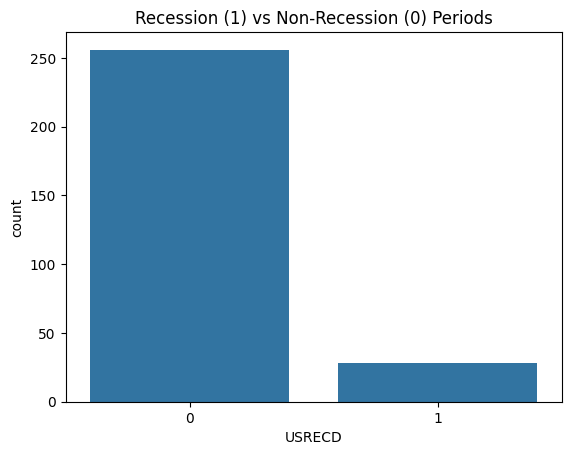

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='USRECD', data=merged_df)
plt.title("Recession (1) vs Non-Recession (0) Periods")
plt.show()


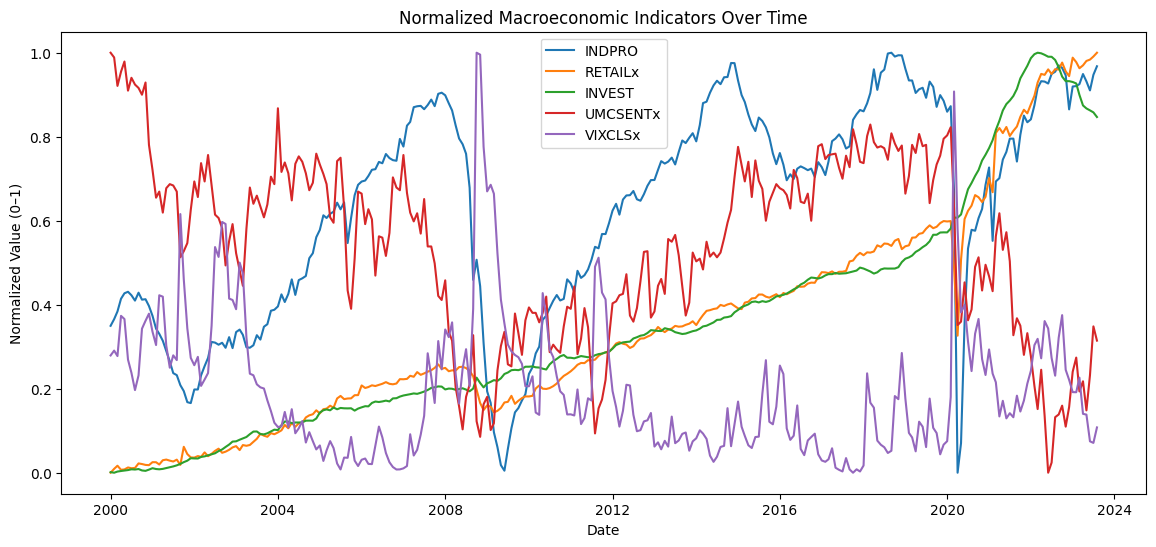

In [ ]:
cols=['INDPRO', 'RETAILx', 'INVEST', 'UMCSENTx', 'VIXCLSx']
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(merged_df[cols])
normalized_df = pd.DataFrame(normalized_data, columns=cols)
normalized_df['sasdate'] = merged_df['sasdate']

plt.figure(figsize=(14, 6))
for col in cols:
    plt.plot(normalized_df['sasdate'], normalized_df[col], label=col)

plt.legend()
plt.title("Normalized Macroeconomic Indicators Over Time")
plt.xlabel("Date")
plt.ylabel("Normalized Value (0–1)")
plt.show()



In [ ]:
corr_matrix = merged_df.corr()


In [ ]:
target = 'INDPRO'
cor_target = corr_matrix[target].abs()
important_features = cor_target[cor_target > 0.5].sort_values(ascending=False)


<Axes: >

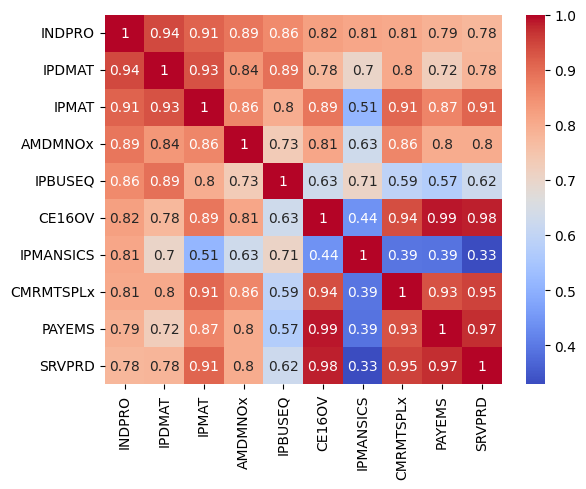

In [ ]:
top10 = cor_target.sort_values(ascending=False).head(10).index
sns.heatmap(merged_df[top10].corr(), annot=True, cmap='coolwarm')


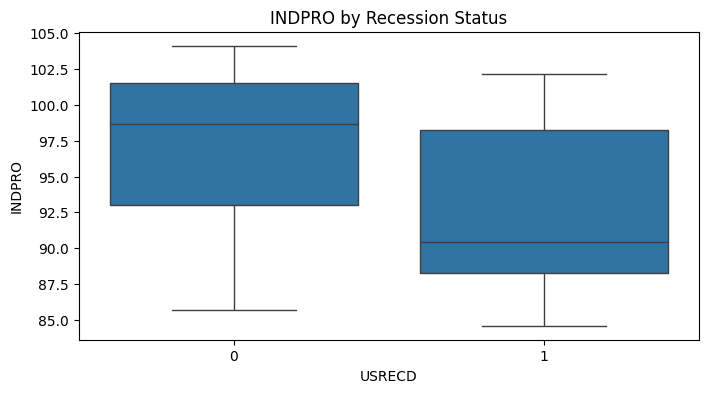

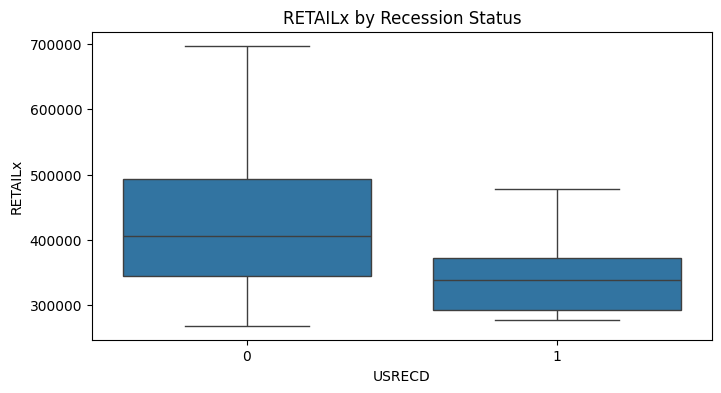

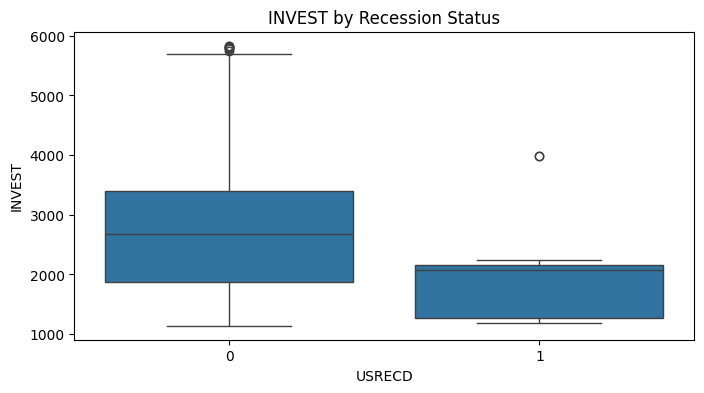

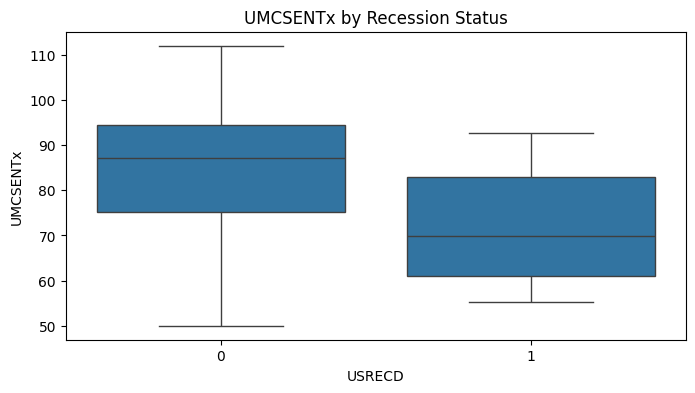

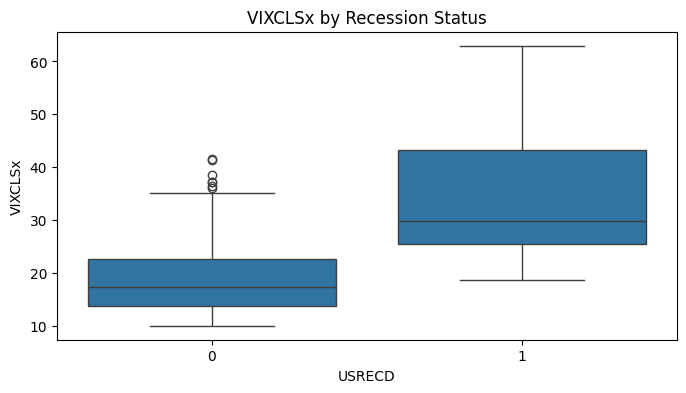

In [ ]:
for col in ['INDPRO', 'RETAILx', 'INVEST', 'UMCSENTx', 'VIXCLSx']:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='USRECD', y=col, data=merged_df)
    plt.title(f"{col} by Recession Status")
    plt.show()


In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Your DataFrame: df (already normalized)

# List of columns to test
columns = ['INDPRO', 'RETAILx', 'INVEST', 'UMCSENTx', 'VIXCLSx']

# Function to check stationarity
def check_stationarity(series, name):
    result = adfuller(series.dropna())
    p_value = result[1]
    print(f"{name}: ADF p-value = {p_value:.4f} => {'Stationary ✅' if p_value < 0.05 else 'Non-stationary ❌'}")
    return p_value < 0.05  # True if stationary

# Dictionary to store stationarity result
stationary_flags = {}

# Step 1: Initial check
print("Initial Stationarity Check:")
for col in columns:
    stationary_flags[col] = check_stationarity(df[col], col)

# Step 2: Apply differencing only to non-stationary columns
for col in columns:
    if not stationary_flags[col]:
        df[col + '_diff'] = df[col].diff()
        print(f"\nAfter Differencing {col}:")
        check_stationarity(df[col + '_diff'], col + '_diff')


Initial Stationarity Check:
INDPRO: ADF p-value = 0.3312 => Non-stationary ❌
RETAILx: ADF p-value = 0.9967 => Non-stationary ❌
INVEST: ADF p-value = 0.7149 => Non-stationary ❌
UMCSENTx: ADF p-value = 0.0988 => Non-stationary ❌
VIXCLSx: ADF p-value = 0.0010 => Stationary ✅

After Differencing INDPRO:
INDPRO_diff: ADF p-value = 0.0000 => Stationary ✅

After Differencing RETAILx:
RETAILx_diff: ADF p-value = 0.0005 => Stationary ✅

After Differencing INVEST:
INVEST_diff: ADF p-value = 0.0519 => Non-stationary ❌

After Differencing UMCSENTx:
UMCSENTx_diff: ADF p-value = 0.0000 => Stationary ✅


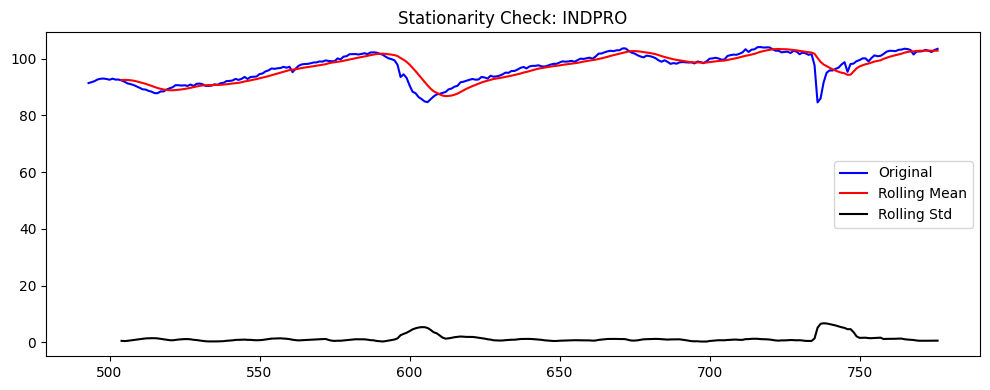

ADF Test for INDPRO:
ADF Statistic : -1.9019
p-value       : 0.3312
Non-stationary
----------------------------------------


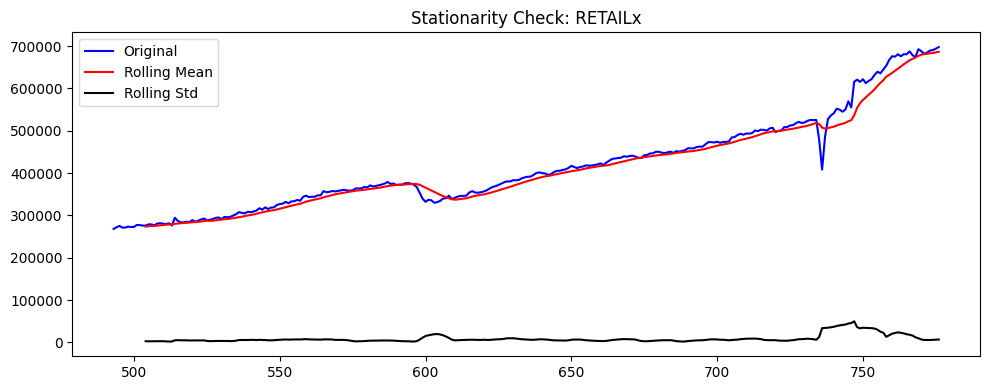

ADF Test for RETAILx:
ADF Statistic : 1.3243
p-value       : 0.9967
Non-stationary
----------------------------------------


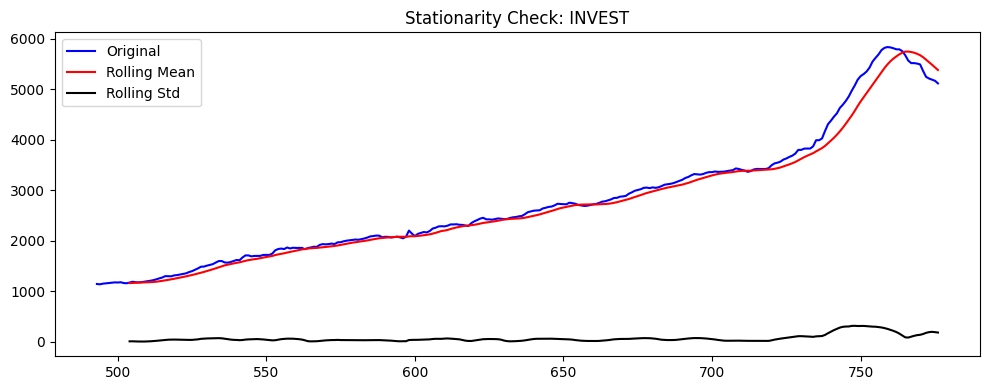

ADF Test for INVEST:
ADF Statistic : -1.1003
p-value       : 0.7149
Non-stationary
----------------------------------------


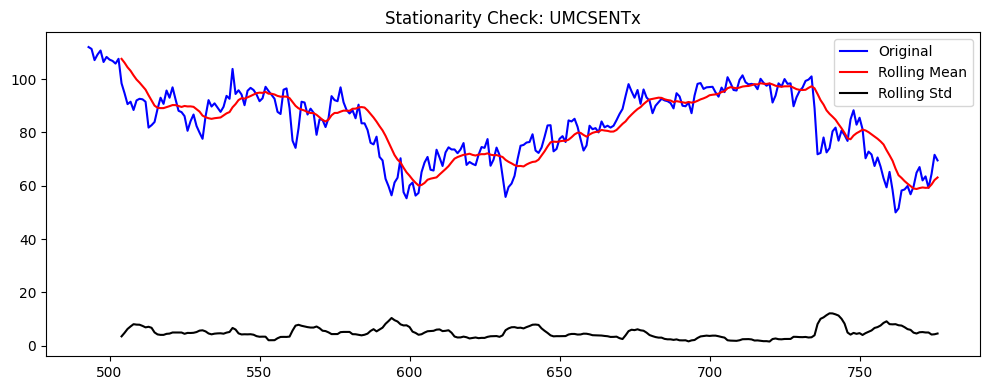

ADF Test for UMCSENTx:
ADF Statistic : -2.5725
p-value       : 0.0988
Non-stationary
----------------------------------------


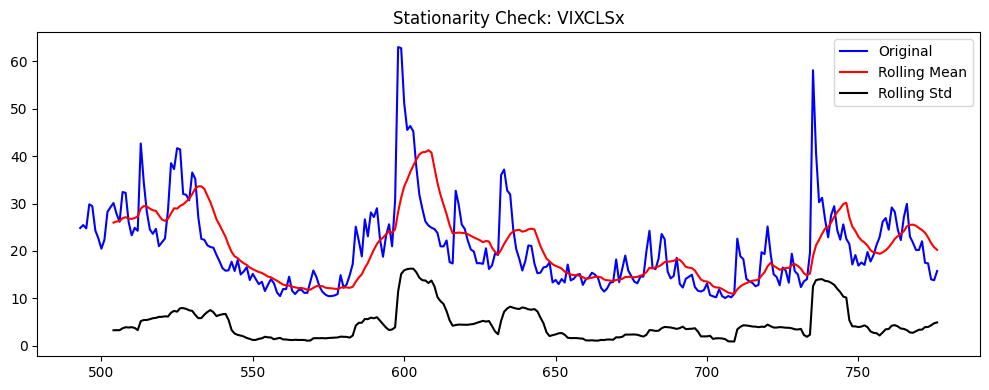

ADF Test for VIXCLSx:
ADF Statistic : -4.1019
p-value       : 0.0010
Stationary
----------------------------------------


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Selected columns
selected_cols = ['INDPRO', 'RETAILx', 'INVEST', 'UMCSENTx', 'VIXCLSx']

# Function to perform ADF test and plot rolling stats
def test_stationarity(series, col_name):
    rolmean = series.rolling(window=12).mean()
    rolstd = series.rolling(window=12).std()

    # Plot rolling stats
    plt.figure(figsize=(10, 4))
    plt.plot(series, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.title(f'Stationarity Check: {col_name}')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Perform Dickey-Fuller test
    result = adfuller(series.dropna())
    print(f'ADF Test for {col_name}:')
    print(f'ADF Statistic : {result[0]:.4f}')
    print(f'p-value       : {result[1]:.4f}')
    print('Stationary' if result[1] < 0.05 else 'Non-stationary')
    print('-'*40)

# Run for each column
for col in selected_cols:
    test_stationarity(df[col], col)


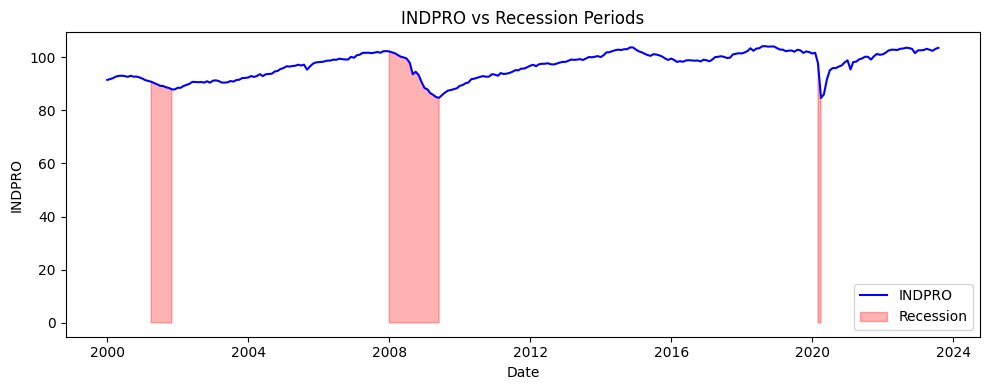

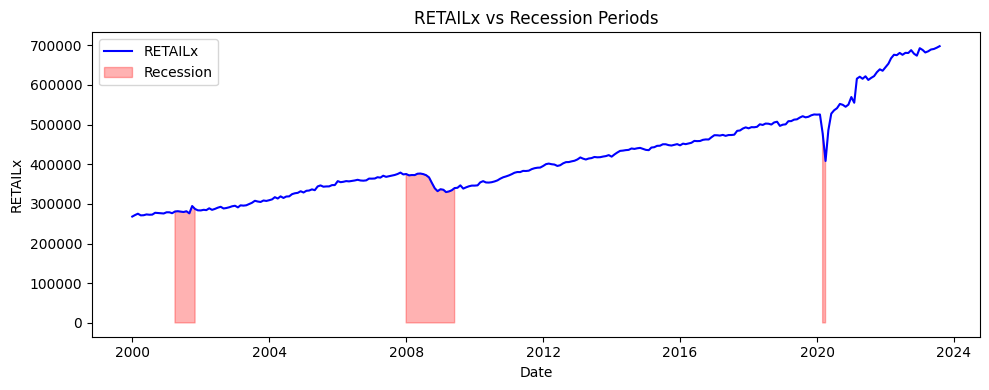

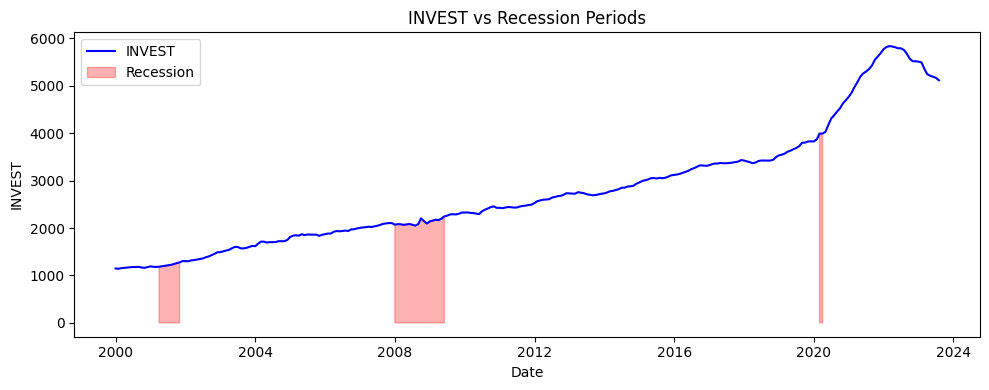

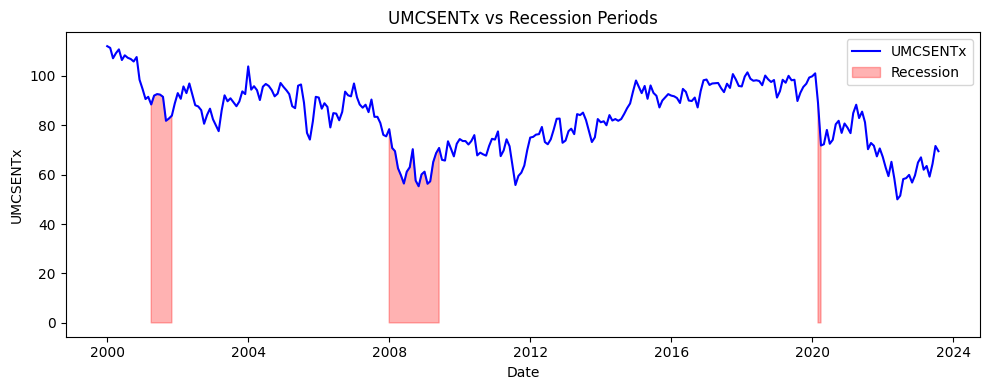

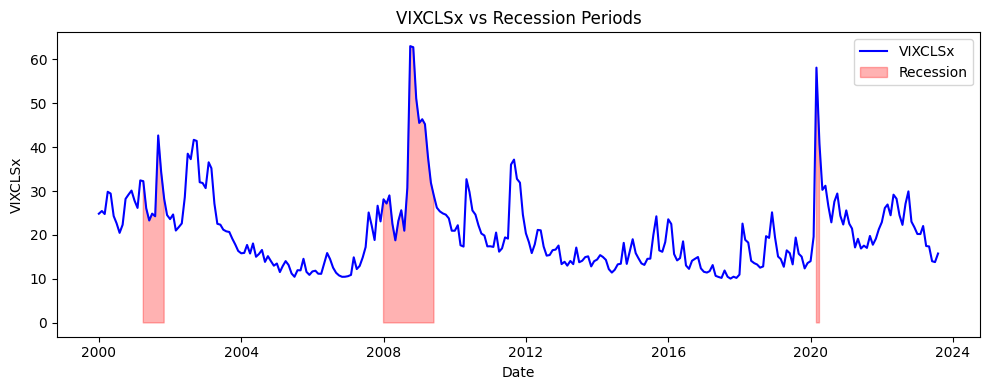

In [ ]:
import matplotlib.pyplot as plt

selected_cols = ['INDPRO', 'RETAILx', 'INVEST', 'UMCSENTx', 'VIXCLSx']

# Plotting each selected feature against recession periods
for col in selected_cols:
    plt.figure(figsize=(10, 4))
    plt.plot(df['sasdate'], df[col], label=col, color='blue')
    plt.fill_between(merged_df['sasdate'], 0, df[col], where=merged_df['USRECD']==1, color='red', alpha=0.3, label='Recession')
    plt.title(f'{col} vs Recession Periods')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
correlations = merged_df[selected_cols + ['USRECD']].corr()['USRECD'].sort_values(ascending=False)
print(correlations)


USRECD      1.000000
VIXCLSx     0.536472
INVEST     -0.207978
RETAILx    -0.229025
UMCSENTx   -0.293991
INDPRO     -0.297800
Name: USRECD, dtype: float64
